# **ВТОРАЯ ЧАСТЬ  - LINEAR REGRESSION'**

---

*   На основе данных в файле train.csv научить модель, которая по любым параметрам из файла будет предсказывать колонку revenue_30d_total.
*   Цель: максимально точно предсказать это значение.
*   Метрика контроля качества: относительная ошибка на каждом пользователе:(predicted_revenue_30d_total - revenue_30d_total) / revenue_30d_total
*   Можно пользоваться любыми фреймворками и типами моделей. Но желательно объяснить выбор того или иного инструмента. 



# **ИМПОРТ БИБЛИОТЕК**

---

In [1]:
from matplotlib import pyplot
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.stats as stats


from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler
import sklearn.linear_model as lm
from sklearn.model_selection import train_test_split, cross_validate, KFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, mean_absolute_error
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score, mean_squared_error

import pickle
!pip install scipy==1.7.1
import time
import sys
import os
import warnings
warnings.filterwarnings('ignore')



from jupyterthemes import jtplot
jtplot.style(context='notebook', ticks=True, grid=False)

!pip install lightgbm
import lightgbm as lgb

# **ЗАГРУЗКА ФИН ДАТАСЕТ**


---

In [2]:
# подготовим абсолютный путь до папки с данными
path = os.path.expanduser('~/PycharmProjects/Brightika_test/')
path
start = time.time() # включим таймер для подсчета времени чтения файла в датасет
train = pd.read_csv(path + 'train_out_outliers.csv')

In [3]:
train['revenue_30d_total'].describe().apply(lambda x: f'{x:0.8f}')

count    4125714.00000000
mean           0.17701312
std            0.93278879
min            0.00000000
25%            0.00350078
50%            0.01942773
75%            0.08062470
max          178.39592106
Name: revenue_30d_total, dtype: object

# ПОДГОТОВКА К МОДЕЛИРОВАНИЮ 

## Feature generation
Существуют различные способы повышения качества работы моделей машинного обучения.
Одним из таких способов является создание новых признаков. 
в блокноте 1 части я создала доп признаки 
1) install_date_month - месяц установки пользователем приложения (первый вход)
2) install_date_day -  день установки пользователем приложения (первый вход)
3) user_agent -  Android тип устройства из идентификационная строка клиентского приложения

создадим доп признак день недели
4) install_date_weekday - установка день недели
5) revenue_30d_total_median_per_os - медиана по выручке в зависимости от типа ОС
6) revenue_30d_total_median_per_lan - медиана по выручке в зависимости от типа языка
удалим все категор колонки, которые не будут учавствовать в моделировании
install_date
random_user_id

In [4]:
train['install_date'] = pd.to_datetime(train.install_date, utc=True)
train['install_date_weekday'] = train['install_date'].dt.weekday

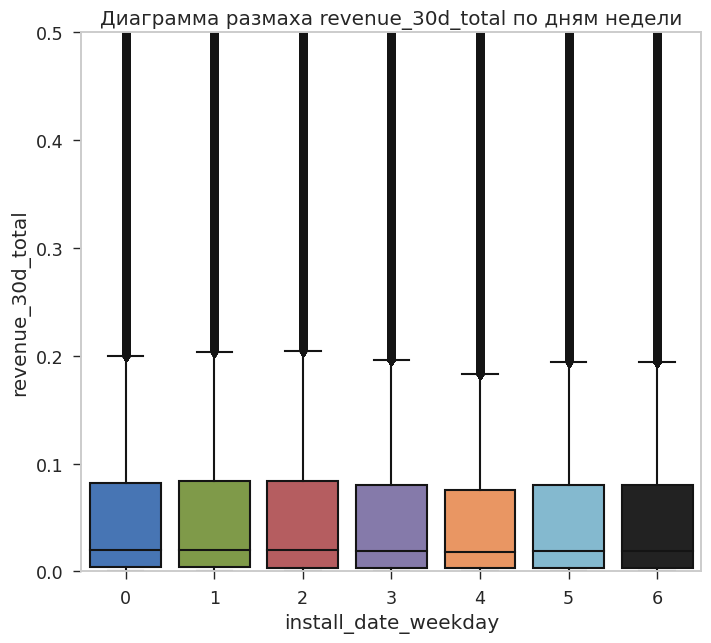

In [5]:
sns.boxplot(x=train["install_date_weekday"], y=train['revenue_30d_total']);
plt.ylim(0, 0.5)
plt.title('Диаграмма размаха revenue_30d_total по дням недели');

lang_count = train.groupby('Android').agg(revenue_30d_total_median_per_os=('revenue_30d_total', np.median)).fillna(method='ffill').reset_index()
train = pd.merge(train, lang_count, how='left', on='Android')
train[['revenue_30d_total_median_per_os', 'revenue_30d_total']].head(3)

lang_count = train.groupby('Android').agg(revenue_30d_total_mean_per_os=('revenue_30d_total', np.mean)).fillna(method='ffill').reset_index()
train = pd.merge(train, lang_count, how='left', on='Android')
train[['revenue_30d_total_mean_per_os', 'revenue_30d_total']].head(3)

lang_count = train.groupby('language').agg(revenue_30d_total_median_per_lan=('revenue_30d_total', np.median)).fillna(method='ffill').reset_index()
train = pd.merge(train, lang_count, how='left', on='language')
train[['revenue_30d_total_mean_per_os', 'revenue_30d_total']].head(3)

lang_count = train.groupby('language').agg(revenue_30d_total_mean_per_lan=('revenue_30d_total', np.mean)).fillna(method='ffill').reset_index()
train = pd.merge(train, lang_count, how='left', on='language')
train[['revenue_30d_total_mean_per_lan', 'revenue_30d_total']].head(3)

In [6]:
# добавим новые фичи (частота встречаемости языка)
lan = train['language'].value_counts().reset_index().set_axis(['language', 'language_count'], axis=1)
train = pd.merge(train, lan, how='left', on='language')
train = train.drop(['install_date','random_user_id','Android', 'language'], axis=1)

In [7]:
def sqr_sqrt_log_features_transform(train: pd.DataFrame,
                                        sqrt_miss: list=None,
                                        log_miss: list=None,
                                   ) -> pd.DataFrame:
    """
    Function transforms dataset adding squares, square roots and logarithm of numerical features
    
    :param df:  input data frame
    :sqr_miss:  columns, that should be missed for square feature generation
    :sqrt_miss: columns, that should be missed for square root feature generation
    :log_miss:  columns, that should be missed for logarithm feature generation
    
    :return:    dataframe with added features
    """
    
    df = train.copy()
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if ~np.isin(col, sqrt_miss):
            df[f'{col}_sqrt'] = np.sqrt(df[col])
        if ~np.isin(col, log_miss):
            df[f'{col}_log'] = np.log(df[col] + 0.01)    
    return df

In [8]:
train = sqr_sqrt_log_features_transform(train, 
                                       sqrt_miss=['revenue_30d_total'],
                                       log_miss=['revenue_30d_total'],
                                     )
train.shape

(4125714, 64)

# **НОРМАЛИЗАЦИЯ, СТАБИЛИЗАЦИЯ ДАННЫХ**
нормализация нужна, чтобы привезти данные к нормальному виду [0:1]
чтобы переменная не могла влиять на другую больше чем остальные


In [9]:

for_stand=train[['revenue_24h_rewards', 'revenue_24h_total', 'revenue_24h_banner', 'revenue_24h_inters',
'api_level', 'sessions_24h', 'screen_inches_diagonal', 'ad_views_24h_rewards', 'ad_views_24h_total',
'device_price', 'screen_pixels_width', 'conversion_duration']]


std_scaler = StandardScaler()
std_scaler
std_scaler.fit(for_stand)
print('Среднее:', std_scaler.mean_)
print('Дисперсия', std_scaler.var_)
std_scaled = std_scaler.transform(for_stand)



Среднее: [1.77753431e-02 7.46125017e-02 9.89730000e-03 4.69398585e-02
 2.92092191e+01 1.74585248e+00 6.46785221e+00 2.16965039e+00
 3.27863516e+01 1.69040147e+02 8.56888954e+02 1.11683903e+04]
Дисперсия [7.89970851e-03 7.46299150e-02 1.53894151e-03 3.17609296e-02
 3.17087290e+00 1.60188180e+00 3.51584997e-01 3.05335837e+01
 4.38762026e+03 7.03529090e+04 5.79864825e+04 5.60001961e+09]


In [10]:
# запишем новые значение стандартизированных данных (взяты из модели baseline после первой прогонки)
# это топ фич по вкладу в модель
train[['revenue_24h_total_std', 'revenue_24h_banner_std', 'revenue_24h_inters_std',
        'revenue_24h_rewards_std', 'ad_views_24h_total_std',
        'ad_views_24h_rewards_std', 'sessions_24h_std',
        'conversion_duration_std', 'api_level_std', 'device_price_std',
        'screen_inches_diagonal_std','screen_pixels_width_std'
        ]] = std_scaled  


# **BASELINE**

## train-test split
Запустим 1ый расчет модели - линейная регрессия
Для того, чтобы понять, какие параметры подобрать используем GridSearchCV
по результатам прогона получилось copy_X': False, 'fit_intercept': True, 'n_jobs': 1, 'normalize': False
Используем эти параметры при прогонке первой модели

In [11]:
train_no_revenue=train.drop(['revenue_30d_total'], axis=1)
train_no_revenue.shape
X=train_no_revenue
y=train['revenue_30d_total']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)

from sklearn.model_selection import GridSearchCV
lr = LinearRegression()
lr.fit(x_train, y_train)
from sklearn.model_selection import GridSearchCV
params = {
            "fit_intercept": [False, True],
            "normalize": [False, True],
            "copy_X": [False, True],
            "n_jobs": [1, None]}


grid = GridSearchCV(lr, params, cv=5)
1 + 1
grid.fit(x_train, y_train)

grid.best_params_

## оценка точности модели
точность получилась не очень хорошая Train: 0.43691428171330227,  Test: 0.4368361322991223
нужно повышать кач-во модели 

Метрика контроля качества: относительная ошибка на каждом пользователе: (predicted_revenue_30d_total - revenue_30d_total) / revenue_30d_total

In [12]:
lr=LinearRegression(copy_X=False, fit_intercept=True, n_jobs=1, normalize=False)
#scaler=StandardScaler()
#train_no_revenue = scaler.fit_transform(X)
baseline_model = lr.fit(x_train, y_train)
print(f'Train: {baseline_model.score(x_train, y_train)},  Test: {baseline_model.score(x_test, y_test)}')

#Расчет cross_val_score на тренировочной выборке.
pred = lr.predict(x_train)
print('Точность baseline LinRegr модели', cross_val_score(lr, X, y, cv=4))

Train: 0.4348002639090637,  Test: 0.43998159374031987
Точность baseline LinRegr модели [0.42009281 0.43281063 0.42736549 0.47269347]


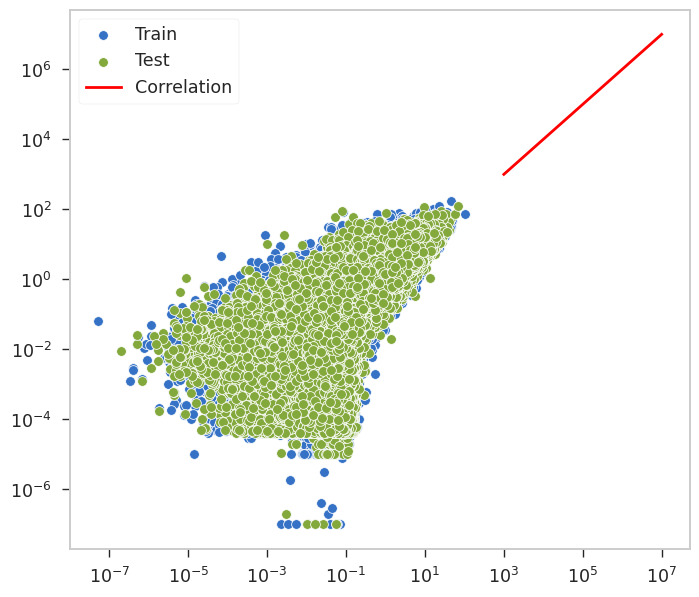

In [13]:
sns.scatterplot(x=baseline_model.predict(x_train), y=y_train.values).set(xscale="log", yscale="log")
sns.scatterplot(x=baseline_model.predict(x_test), y=y_test.values).set(xscale="log", yscale="log")
plt.plot([1e3, 1e7], [1e3, 1e7], 'red', linewidth=2)
plt.legend(labels=['Train', 'Test', 'Correlation'])
plt.show()

In [14]:
#Выведем фичи, значение которых не равны 0, те все вносят вклад и отсортируем их 
lr.coef_
list_coef = list(zip(train_no_revenue.columns, lr.coef_))
list_coef.sort(key = lambda x: x[1], reverse=True)
print('Features, коэффициенты которых не равны нулю =', len(list_coef))
list_coef= pd.DataFrame({"features": train_no_revenue.columns, "feature_importances": lr.coef_})
# обрежем features, которые имеют вклад 0 в модель, ушло 45 features 
f_imp_list_cut = list_coef.loc[list_coef['feature_importances']>0, :]
f_imp_list_cut['feature_importances'].describe()

 # Удалим фичи с нулевыми весами по feature_importance из тренировочной и тестовой выборок.
columns_mask = (lr.coef_ != 0)
x_train_clear = x_train[x_train.columns[columns_mask]]
x_test_clear = x_test[x_test.columns[columns_mask]]

Features, коэффициенты которых не равны нулю = 75


In [15]:
 # Заново обучите модель и измерьте качество.
x_train_clear, x_test_clear, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
lr=LinearRegression(copy_X=False, fit_intercept=True, n_jobs=1, normalize=False)
#scaler=StandardScaler()
#train_no_revenue = scaler.fit_transform(X)
baseline_model = lr.fit(x_train_clear, y_train)
print(f'Train: {baseline_model.score(x_train_clear, y_train)},  Test: {baseline_model.score(x_test_clear, y_test)}')

#Расчет  cross_val_score на тренировочной выборке.
pred = lr.predict(x_train_clear)
print('Точность baseline LinRegr модели', cross_val_score(lr, X, y, cv=4))

Train: 0.43874232515608025,  Test: 0.4314555687324516
Точность baseline LinRegr модели [0.42009281 0.43281063 0.42736549 0.47269347]


In [16]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
pd.set_option('display.width', 2500)

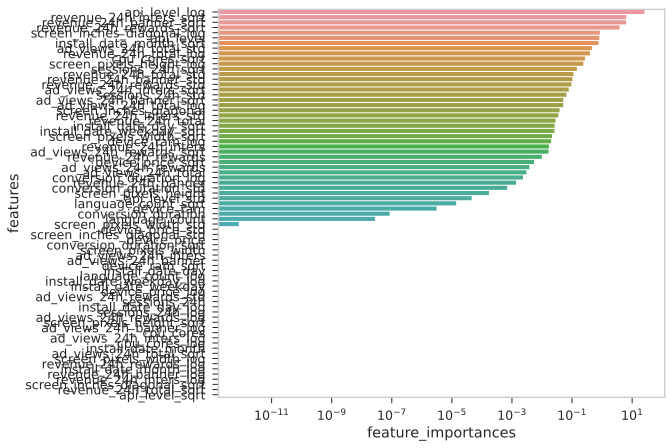

<Figure size 800x700 with 0 Axes>

In [17]:
## Выведем фичи, значения которых максимально вносят вклад в модель, логично, что это все revenue
list_coef = list_coef.sort_values('feature_importances', ascending=False) 
sns.barplot(list_coef['feature_importances'], list_coef['features']).set(xscale="log")  
plt.figure()  
plt.show() 
sns.set (font_scale=0.7)

# извлечем из модели колонку предсказание выручки
сделаем df состоящий из актуальнйо выручки, предсказанной и ошибки, которую по заданию необходимо оценить
видим, что по статистике предсказине имеет большую ошибку на максим значений (порядок сильно разница и на минимальных)

In [18]:
#извлечем колонку со значениями predict 
pred=pd.DataFrame({"prediction": pred})
pred_df = pd.merge(train['revenue_30d_total'], pred, left_index=True, right_index=True)
#запишем его в датафрейм по формуле (predicted_revenue_30d_total - revenue_30d_total) / revenue_30d_total
pred_df['relev_error']=(pred_df['prediction']-pred_df['revenue_30d_total'])/(pred_df['revenue_30d_total'])

In [19]:
#продублируем и посмотрим это же значением. если брать абсолютные значения, можно ли избежать деления на 0
import numpy as np

def relev_error(A, F):
    with np.errstate(divide='ignore', invalid='ignore'):
        tmp = (np.abs(A) - np.abs(F)) / np.abs(F)
    
    return tmp

print('relev_error прогноза выручки =',relev_error(pred_df.prediction, pred_df.revenue_30d_total))


relev_error прогноза выручки = 0               inf
1          2.965447
2         -0.848100
3          5.198023
4          0.891547
             ...   
2887994    8.633290
2887995   -0.893641
2887996         inf
2887997    7.753174
2887998   -0.130852
Length: 2887999, dtype: float64


In [20]:
#запишем полученное значение relev_error в датасет
rel_error=relev_error(pred_df.prediction, pred_df.revenue_30d_total)
pred_error=pd.DataFrame({"relev_error_formule": rel_error})
pred_error_df = pd.merge(pred_df, pred_error, left_index=True, right_index=True)

In [21]:
#заменим значения inf на 0
pred_error_df.loc[pred_error_df['relev_error_formule'] > 180, 'relev_error_formule'] = pred_error_df['relev_error_formule'].apply(lambda x: 0)
pred_error_df.loc[pred_error_df['relev_error'] > 180, 'relev_error'] = pred_error_df['relev_error'].apply(lambda x: 0)

In [22]:
#также расчитаем значением smape Symmetric mean absolute percentage error менее чувствителен к 0 значениям

import numpy as np

def smape(A, F):
    with np.errstate(divide='ignore', invalid='ignore'):
        tmp = 2 * np.abs(F-A) / (np.abs(A) + np.abs(F))
    tmp[np.isnan(tmp)] = 0
    return tmp
print('smape прогноза выручки =',smape(pred_df.prediction, pred_df.revenue_30d_total))

smape прогноза выручки = 0          2.000000
1          2.000000
2          1.472523
3          1.444292
4          0.616657
             ...   
2887994    1.623823
2887995    2.000000
2887996    2.000000
2887997    2.000000
2887998    2.000000
Length: 2887999, dtype: float64


In [23]:
#запишем полученное значение smape в датасет
smape_f=smape(pred_df.prediction, pred_df.revenue_30d_total)
smape_df=pd.DataFrame({"smape_error": smape_f})
pred_error_df = pd.merge(pred_error_df, smape_df, left_index=True, right_index=True)

# Оценка метрики контроля качества на линейной модели train данные


In [24]:
pd.options.display.float_format = '{:.5f}'.format
pred_error_df.describe()

,revenue_30d_total,prediction,relev_error,relev_error_formule,smape_error
count,2887999.00000,2887999.00000,2887999.00000,2887999.00000,2887999.00000
mean,0.20299,0.17664,-inf,8.01041,1.50032
std,1.05468,0.61467,NaN,22.57462,0.60083
min,0.00000,-0.29877,-inf,-1.00000,0.00000
25%,0.00350,0.00673,-0.95371,-0.53174,1.10382
50%,0.01985,0.04782,0.00000,0.00000,1.79120
75%,0.08597,0.12082,3.21540,4.50689,2.00000
max,178.39592,110.38463,179.99970,179.99970,2.00000


(0.0, 10.0)

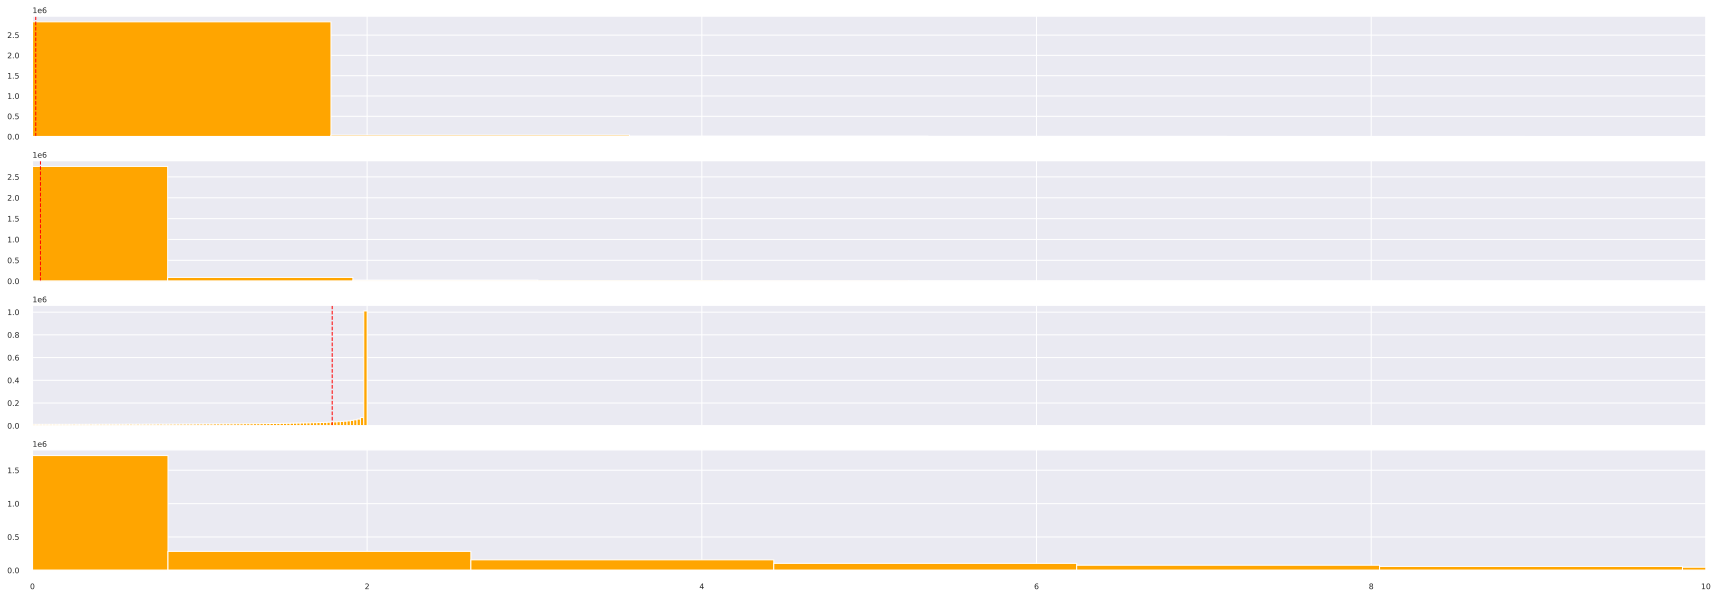

In [25]:
from matplotlib.ticker import FormatStrFormatter
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, figsize=(30, 10), sharex=True)

ax1.hist(pred_error_df.revenue_30d_total, bins=100, color='orange')
ax1.axvline(pred_error_df.revenue_30d_total.median(), color='red', linestyle='dashed', linewidth=1)

ax2.hist(pred_error_df.prediction, bins=100, color='orange')
ax2.axvline(pred_error_df.prediction.median(), color='red', linestyle='dashed', linewidth=1)


ax3.hist(pred_error_df.smape_error, bins=100, color='orange')
ax3.axvline(pred_error_df.smape_error.median(), color='red', linestyle='dashed', linewidth=1)


ax4.hist(pred_error_df.relev_error_formule, bins=100, color='orange')
ax4.axvline(pred_error_df.relev_error_formule.median(), color='red', linestyle='dashed', linewidth=1)

ax1.set_xlim([0, 10])

# Прогон модели на тестовом файле test.csv


In [26]:
test = pd.read_csv(path + 'test_out_outliers.csv')

In [27]:
# добавим новые фичи (install_date)
test['install_date'] = pd.to_datetime(test.install_date, utc=True)
test['install_date_weekday'] = test['install_date'].dt.weekday
# добавим новые фичи (частота встречаемости языка)
lan = test['language'].value_counts().reset_index().set_axis(['language', 'language_count'], axis=1)
test = pd.merge(test, lan, how='left', on='language')

In [28]:
test = test.drop(['install_date', 'random_user_id','Android', 'language'], axis=1)

In [29]:
# добавим новые фичи (sqr_sqrt_log_features_transform)
test = sqr_sqrt_log_features_transform(test, 
                                       sqrt_miss=['revenue_30d_total'],
                                       log_miss=['revenue_30d_total'],
                                     )

In [30]:
# выполняем стандартизацию данных
for_stand_test=test[['revenue_24h_rewards', 'revenue_24h_total', 'revenue_24h_banner', 'revenue_24h_inters',
'api_level', 'sessions_24h', 'screen_inches_diagonal', 'ad_views_24h_rewards', 'ad_views_24h_total',
'device_price', 'screen_pixels_width', 'conversion_duration']]
std_scaler.fit(for_stand_test)

print('Среднее:', std_scaler.mean_)
print('Дисперсия', std_scaler.var_)
std_scaled = std_scaler.transform(for_stand_test)

Среднее: [1.77389461e-02 7.43703274e-02 9.82544462e-03 4.68059367e-02
 2.92077053e+01 1.74607786e+00 6.46716110e+00 2.17283474e+00
 3.27579578e+01 1.68546564e+02 8.56665191e+02 1.11462244e+04]
Дисперсия [7.76183950e-03 7.36750131e-02 1.45811014e-03 3.14187990e-02
 3.16836849e+00 1.60452087e+00 3.50436092e-01 3.06387177e+01
 4.38151621e+03 6.98845178e+04 5.77948483e+04 5.39152965e+09]


In [31]:
# запишем новые значение стандартизированных данных (взяты из модели baseline после первой прогонки)
# это топ фич по вкладу в модель
test[['revenue_24h_total_std', 'revenue_24h_banner_std', 'revenue_24h_inters_std',
        'revenue_24h_rewards_std', 'ad_views_24h_total_std',
        'ad_views_24h_rewards_std', 'sessions_24h_std',
        'conversion_duration_std', 'api_level_std', 'device_price_std',
        'screen_inches_diagonal_std','screen_pixels_width_std' 
        ]] = for_stand_test  


In [32]:
# убираем колонку revenue_30d_total для начала предсказания
test = test.drop(['revenue_30d_total'], axis=1)

In [33]:
pred = lr.predict(test)

In [34]:
pred=pd.DataFrame({"prediction": pred})
pred_df_test = pd.merge(test['revenue_24h_total'], pred, left_index=True, right_index=True)


In [35]:
pred_df_test

,revenue_24h_total,prediction
0,0.00125,12.76422
1,0.01407,12.76182
2,0.02198,12.67176
3,0.01797,12.68301
4,0.07458,12.61757
...,...,...
1770455,0.00019,12.51686
1770456,0.00890,12.64634
1770457,0.05531,13.01042
1770458,0.02235,12.31761


(array([5.93700e+03, 1.82500e+03, 2.03890e+04, 3.62340e+04, 4.36790e+04,
        1.45904e+05, 4.70962e+05, 8.52684e+05, 1.23149e+05, 2.94650e+04,
        1.44280e+04, 8.21600e+03, 5.10200e+03, 3.43700e+03, 2.37900e+03,
        1.66700e+03, 1.19100e+03, 8.81000e+02, 6.11000e+02, 4.99000e+02,
        3.47000e+02, 3.16000e+02, 2.39000e+02, 1.80000e+02, 1.46000e+02,
        1.15000e+02, 9.20000e+01, 6.60000e+01, 5.50000e+01, 4.40000e+01,
        4.80000e+01, 2.80000e+01, 2.10000e+01, 1.80000e+01, 1.90000e+01,
        1.80000e+01, 1.10000e+01, 5.00000e+00, 7.00000e+00, 6.00000e+00,
        5.00000e+00, 5.00000e+00, 2.00000e+00, 3.00000e+00, 2.00000e+00,
        3.00000e+00, 3.00000e+00, 0.00000e+00, 3.00000e+00, 1.00000e+00,
        1.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00,
        1.00000e+00, 2.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00

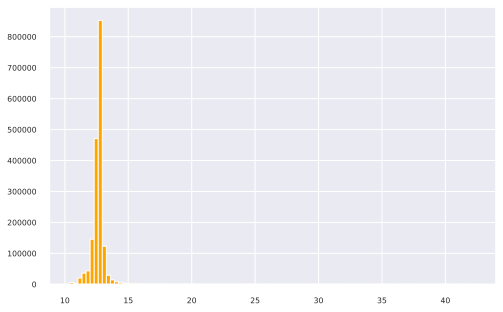

In [36]:
plt.figure(figsize=(8, 5))

plt.hist(pred_df_test.prediction, bins=100, color='orange')
#plt.xlim(-1, 2)

In [37]:
pred_df_test['prediction'].describe()

count   1770460.00000
mean         12.63827
std           0.49833
min          10.39411
25%          12.49510
50%          12.68738
75%          12.78726
max          42.37554
Name: prediction, dtype: float64